In [1]:
%load_ext autoreload
%autoreload 2

In [129]:
import matplotlib.pyplot as plt
import matplotlib.patheffects
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

# from surp.src.analysis import plotting_utils as pluto
from surp.analysis.apogee_analysis import subgiants
import arya
plt.rcParams["figure.dpi"] = 200
import seaborn as sns
from surp.analysis import plotting_utils as pluto
arya.style.init()

from surp._globals import AGB_MODELS

In [3]:
width = 10/3
ϕ = np.sqrt(2)
height = width/ϕ
arya.style.set_size((width, height))
#arya.style.set_fontsize(12)
sns.set_style("ticks")
sns.set_style({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'axes.splines.top': True,
    'axes.splines.right': True,
    'image.cmap': 'arya',
})

In [4]:
def cooh_data(ax=None, **params):
    
    ha = subgiants["high_alpha"]
    df = subgiants[~ha]
    
    arya.binnedplot(df, x="MG_H", y="C_MG", binrange=(-0.5, 0.5), binwidth=0.05,
                              cmin=1, stat="median", errorbar="pi",   **params)
    
def coofe_data(o_0=-0.1, w=0.05, ax=None, **kwargs):

        
    filt = subgiants["MG_H"] > o_0 - w
    filt &= subgiants["MG_H"] < o_0 + w
    df = subgiants[filt]
    arya.binnedplot(df, x="MG_FE", y="C_MG", binrange=(-0.1, 0.5),
                              cmin=1, stat="median", errorbar="pi",   **params)

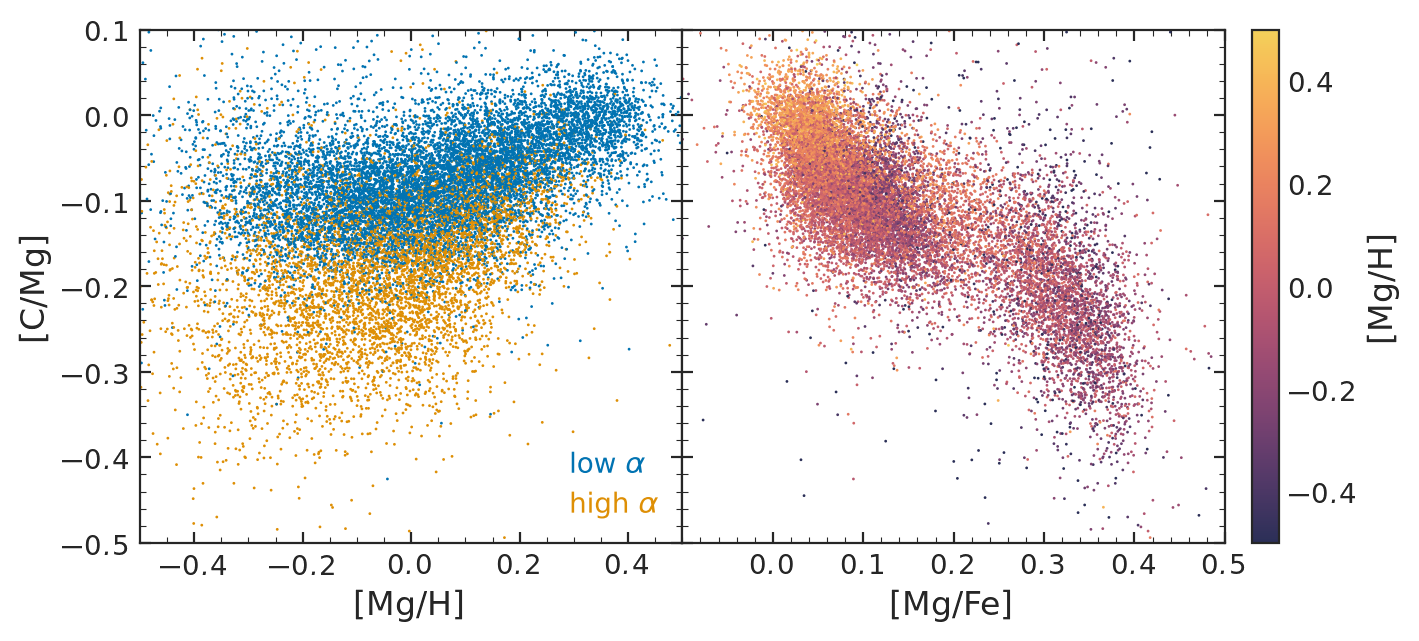

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0})

plt.sca(axs[0])
sns.scatterplot(subgiants, x="MG_H", y="C_MG", hue="high_alpha", s=1, ec="none")
L = arya.Legend(labels=[r"low $\alpha$", r"high $\alpha$"], color_only=True, loc=4)
for text in L.mpl_leg.get_texts():
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                       mpl.patheffects.Normal()])
    
plt.ylabel("[C/Mg]")
plt.xlabel("[Mg/H]")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.1)

plt.sca(axs[1])
sns.scatterplot(subgiants, x="MG_FE", y="C_MG", hue="MG_H", s=1, legend=False, hue_norm=(-0.5, 0.5), palette=plt.get_cmap(), ec="none")
plt.xlim(-0.1, 0.5)
plt.xticks(np.arange(0, 0.51, 0.1))

plt.xlabel("[Mg/Fe]")

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

arya.Colorbar((-0.5, 0.5), label="[Mg/H]", cax=cax)
plt.savefig("subgiants.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


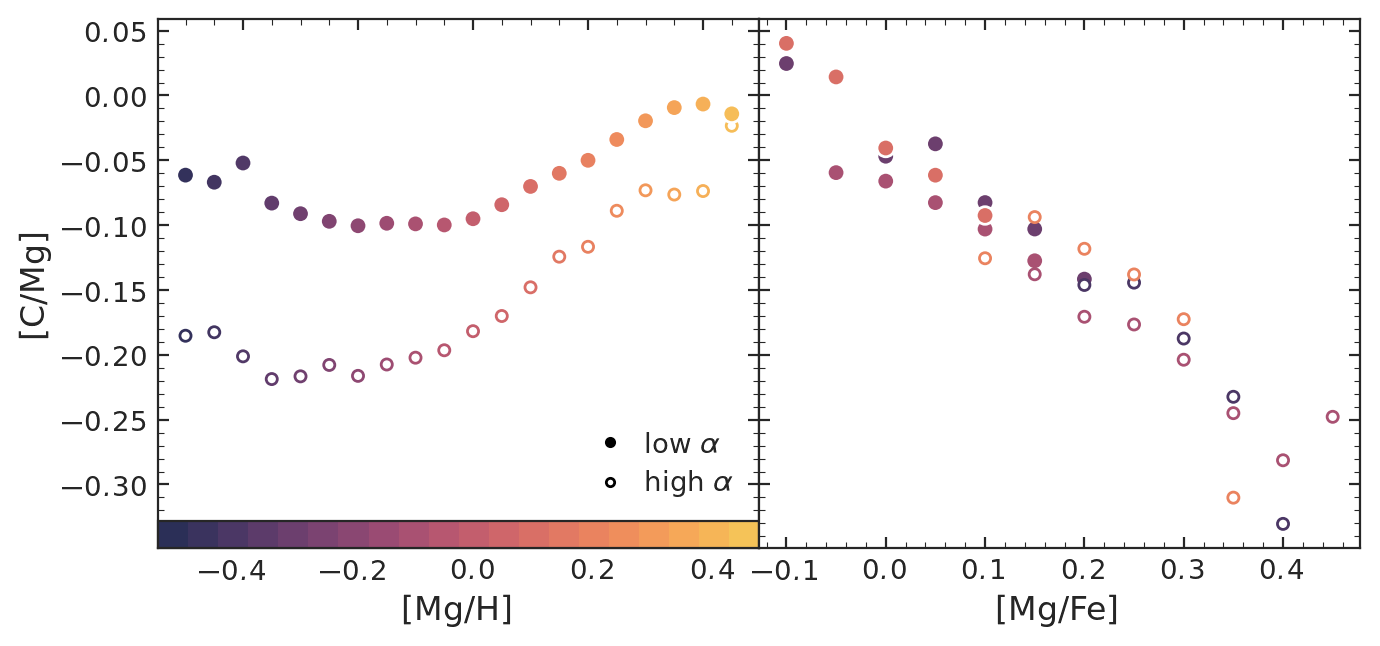

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0})


df1 = subgiants[subgiants.high_alpha]
df2 = subgiants[~subgiants.high_alpha]
plt.sca(axs[0])

d1 = arya.binnedplot(df1, x="MG_H", y="C_MG", binrange=(-0.525, 0.525), binwidth=0.05, hue_binrange=(-0.525,0.525), hue_binwidth=0.05, 
                hue="MG_H", facecolor="w", edgecolor="match", cmin=1, stat="median", errorbar=None, legend=False)

d1 = arya.binnedplot(df2, x="MG_H", y="C_MG", binrange=(-0.525, 0.525), binwidth=0.05, hue_binrange=(-0.525,0.525), hue_binwidth=0.05, 
                hue="MG_H",  cmin=1, stat="median", errorbar=None, legend=False, s=40)

plt.ylabel("[C/Mg]")
plt.xlabel("")

plt.gca().xaxis.set_tick_params(labelbottom=False)

handles = [plt.Line2D([], [], marker="o", color="k", linewidth=0, ms=3), plt.Line2D([], [], marker="o", markeredgecolor="k", markerfacecolor="w", linewidth=0, ms=3)]

plt.legend(handles=handles, labels=[r"low $\alpha$", r"high $\alpha$"], bbox_to_anchor=(1, 0.05), loc=4)


cax = axs[0].inset_axes([0., -0.0, 1, 0.05])
c = arya.Colorbar(norm=np.arange(-0.525, 0.525, 0.05), location="bottom", clim=(-0.5, 0.5), label="[Mg/H]", cax=cax)
c._mpl.set_ticks(np.arange(-0.4, 0.41, 0.2))



df =df2
filt = (-0.125 < df.MG_H) & (df.MG_H < -0.075)
filt |= (-0.325 < df.MG_H) & (df.MG_H < -0.275)
filt |= (0.075 < df.MG_H) & (df.MG_H < 0.125)

dfa = df[filt][["MG_FE", "C_MG", "MG_H", "high_alpha"]]
dfa.dropna()
plt.sca(axs[1])
d = arya.binnedplot(dfa, x="MG_FE", y="C_MG", binrange=(-0.125, 0.525), binwidth=0.05,   
                 hue="MG_H", hue_bins=np.arange(-0.525, 0.525, 0.05), hue_binrange=(-0.5, 0.5), cmin=2, errorbar=None,
                   hue_label="[Mg/H]", stat="median", legend=False, s=40)



df =df1
filt = (-0.125 < df.MG_H) & (df.MG_H < -0.075)
filt |= (-0.425 < df.MG_H) & (df.MG_H < -0.375)
filt |= (0.175 < df.MG_H) & (df.MG_H < 0.225)

dfa = df[filt][["MG_FE", "C_MG", "MG_H", "high_alpha"]]
dfa.dropna()
plt.sca(axs[1])
d = arya.binnedplot(dfa, x="MG_FE", y="C_MG", binrange=(-0.125, 0.525), binwidth=0.05,   
                 hue="MG_H", hue_bins=np.arange(-0.525, 0.525, 0.05), hue_binrange=(-0.5, 0.5), cmin=2, errorbar=None,
                   hue_label="[Mg/H]", stat="median", legend=False, facecolor="w", edgecolor="match")



plt.xlabel("[Mg/Fe]")





plt.tight_layout()
plt.savefig("subgiants.pdf")

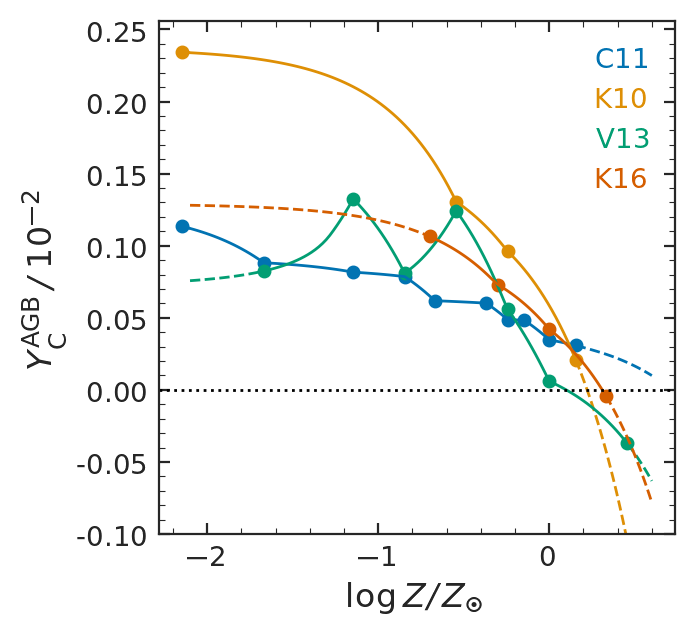

In [159]:
plt.figure(figsize=(10/3, 10/3))

for i in range(len(AGB_MODELS)):
    model = AGB_MODELS[i]

    vice.yields.agb.settings["c"] = model
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)
    
    # plots importaint points
    if type(model) == str:
        y1, m1, z1 = vice.yields.agb.grid('c', study=model)
        Zs = np.array(z1)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 
    y_o_cc = 0.015
    plt.scatter(np.log10(Zs/0.014), y_c_agb)
    MoverH_min = np.log10(min(Zs)/0.014)
    MoverH_max = np.log10(max(Zs)/0.014)
    
    Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    line, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), label=["C11", "K10", "V13", "K16"][i])

    color = line.get_color()

    Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", color=color)

    Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", color=color)

plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$Y_\text{C}^\text{AGB}\,/\,10^{-2}$")

plt.ylim(-0.001)
prop_cycle = plt.rcParams['axes.prop_cycle']

arya.Legend(color_only=True, handlelength=0)
xs= np.arange(-0.001, 0.0026, 0.0005)
plt.yticks(xs, labels=["%0.2f" % a for a in 100*xs])

plt.savefig("y_agb_vs_z.pdf")

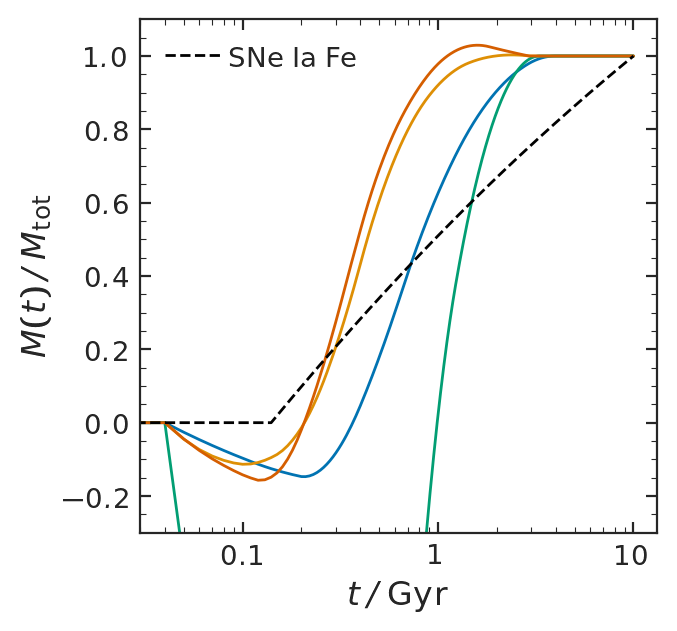

In [152]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0)
    m_c = [c for c in m_c]
    plt.plot(times, np.array(m_c)/m_c[-1])

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
m_fe = [fe for fe in m_fe]
plt.plot(times, np.array(m_fe)/m_fe[-1], label="SNe Ia Fe",
         linestyle="--", color="k")


plt.xlabel(r"$t\,/\,{\rm Gyr}$")
plt.ylabel(r"$M(t)\,/\,M_{\rm tot}$")
plt.xscale("log")
plt.legend()
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

plt.savefig("y_agb_vs_t.pdf")

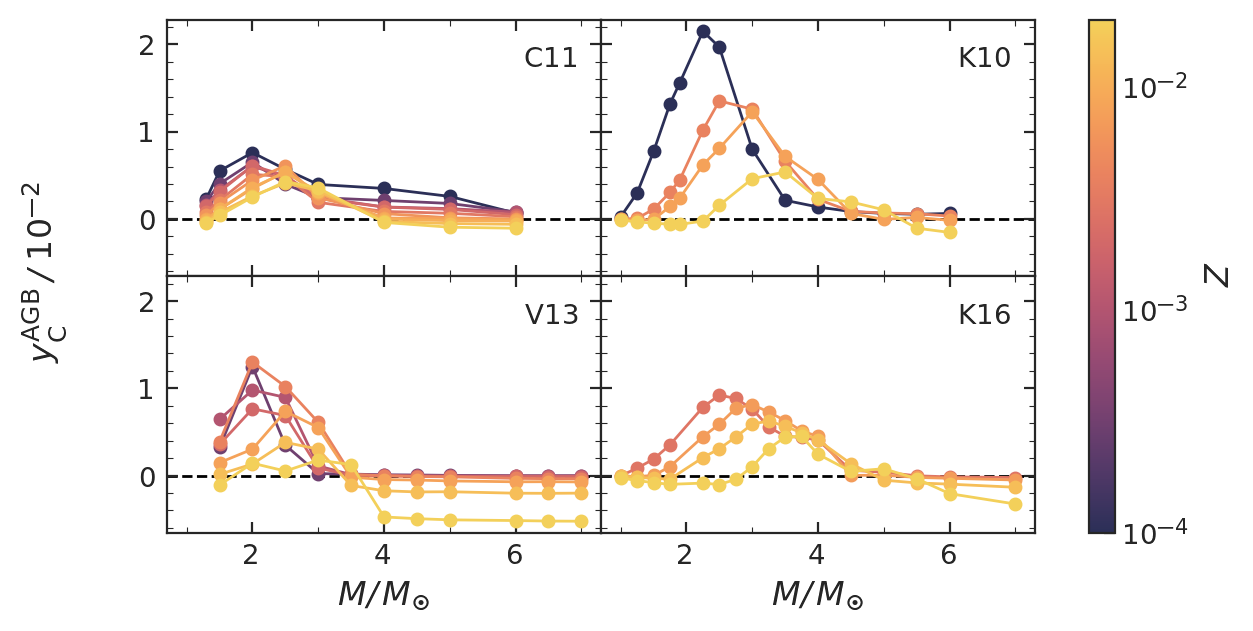

In [166]:

Z_max = 0.02
Z_min = 0.0001
AGB_LABELS = ["C11", "K10", "V13", "K16"]

hmap = arya.figure.colorbar.HueMap((Z_min, Z_max), norm="log")

def plot_c_table(study = "cristallo11", ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    N = len(z1)

    for i in range(N):
        y = 100*np.array(y1)[:,i]
        z = z1[i]
        c = hmap(z)
        f = ax.plot(m1, y, "o", label=f"Z = {z}", c=(c), **kwargs)
        f = ax.plot(m1, y, label=f"Z = {z}", c=(c), **kwargs)
        # ax.set_xticks(np.arange(1, 8))
    
    ax.axhline(0, color="k", ls="--", zorder=-1)

    return f


fig, axs = plt.subplots(2, 2, figsize=(7, 10/3), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
# plt.minorticks_off()

for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    ax = axs[i//2][i%2]
    f = plot_c_table(study, ax=ax, fig=fig)
    ax.text(0.95, 0.9, label, horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)
    #plt.legend()
    # ax.tick_params(
    #         length=5
    #         )



norm = mpl.colors.Normalize(vmin=np.log10(Z_min/0.014), vmax=np.log10(Z_max/0.014))
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), label=r"$Z$")

plt.setp(axs[-1, :], xlabel=r'$M/M_\odot$')
fig.supylabel(r'$y_{\rm C}^{\rm AGB} \,/\,10^{-2}$')

plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

plt.savefig("agb_yields.pdf")

In [172]:
# some studies have -inf values, which are ignored
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "S16/W18": [0],
    "S16/W18F": [0],
    #"CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "S16/W18": [0],
    "S16/W18F": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

M_max = {
    "LC18": 120,
    "S16/N20": 120,
    "S16/W18": 120,
    "S16/W18F": 120,
    "NKT13": 40,
    "WW95": 40,
    "CL04": 35,
    "CL13": 120,
}

ccsne_studies = ["LC18", "S16/W18F", "S16/N20", "S16/W18", "NKT13", "WW95"]

colors = [arya.style.COLORS[i] for i in [0,1,1,1,2,3,4]]
markers = ["o", "s", "d", "D", "*", "^"]
sizes = [30, 30,30,10,30,30]
N = len(ccsne_studies)


def plot_analy():


    m_h = np.linspace(-0.6, 0.5, 1000)
    Z = 0.014*10**m_h
    plt.plot(m_h, y_c_cc(Z), color="k")
    
    m_h = np.linspace(-4, -0.6, 1000)
    Z = 0.014*10**m_h
    plt.plot(m_h, y_c_cc(Z), color="k", ls="-", zorder=-2, label="Analytic")

def plot_c11():
    vice.yields.agb.settings["c"] = "cristallo11"
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)

    MoverH_min = np.log10(min(Zs)/0.014)
    MoverH_max = np.log10(max(Zs)/0.014)

    Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    line, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), label="C11 (AGB)", color=colors[-1])



In [173]:
def plot_y_cc(ele='c'):
    for i in range(N):
        study=ccsne_studies[i]
        metalicities = allowed_MoverH[study]
        rotations = allowed_rotations[study]
        m_upper = M_max[study]

        for j in range(len(rotations)):
            rotation = rotations[j]

            y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity, 
                rotation=rotation, m_upper=m_upper)[0]
                 for metalicity in metalicities]

            marker = markers[i]
            color = colors[i]
            if np.isinf(metalicities[0]):
                if study == "WW95":
                    x0 = -4.5
                    y0 = -0.000
                    ms = 5
                    zorder = 2
                else:
                    x0 = -4.5
                    y0 = 0
                    ms = 6
                    zorder = 3
                plt.errorbar(x0, y[0] + y0, xerr=[0.2], fmt=marker, color=color, 
                             xuplims=[1],ms=ms, zorder=zorder, capsize=0)
                x = metalicities[1:]
                y = y[1:]
            else:
                x = metalicities

            if rotation == 150:
                linestyle="-"
                facecolor=(1,1,1,0)
                label=""
            elif rotation == 300:
                linestyle = ":"
                facecolor=(1,1,1,0)
                label=""
            else:
                linestyle="-"
                facecolor = color
                label=study
            
            plt.scatter(x, y, ec=color, label=label,
                        ls=linestyle, lw=1, fc=facecolor, 
                         marker=marker, s=sizes[i])


In [199]:
plt.legend?

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(handles, labels)
    legend(handles=handles)
    legend(labels)

The call signatures correspond to the following different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

.. note::
    Specific artists can be excluded from the automatic legend element
    selection by using a label starting with an underscore, "_".
    A string starting with an underscore is the default label for all
    artis

/tmp/ipykernel_205029/2404430738.py:11: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


[-3, -2, -1, 0]
[-3, -2, -1, 0]
[-3, -2, -1, 0]
[0]
[0]
[0]
[-inf, -1.15, -0.54, -0.24, 0.15, 0.55]
[-inf, -4, -2, -1, 0]


/tmp/ipykernel_205029/3603439436.py:45: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity,
/tmp/ipykernel_205029/3603439436.py:48: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity,


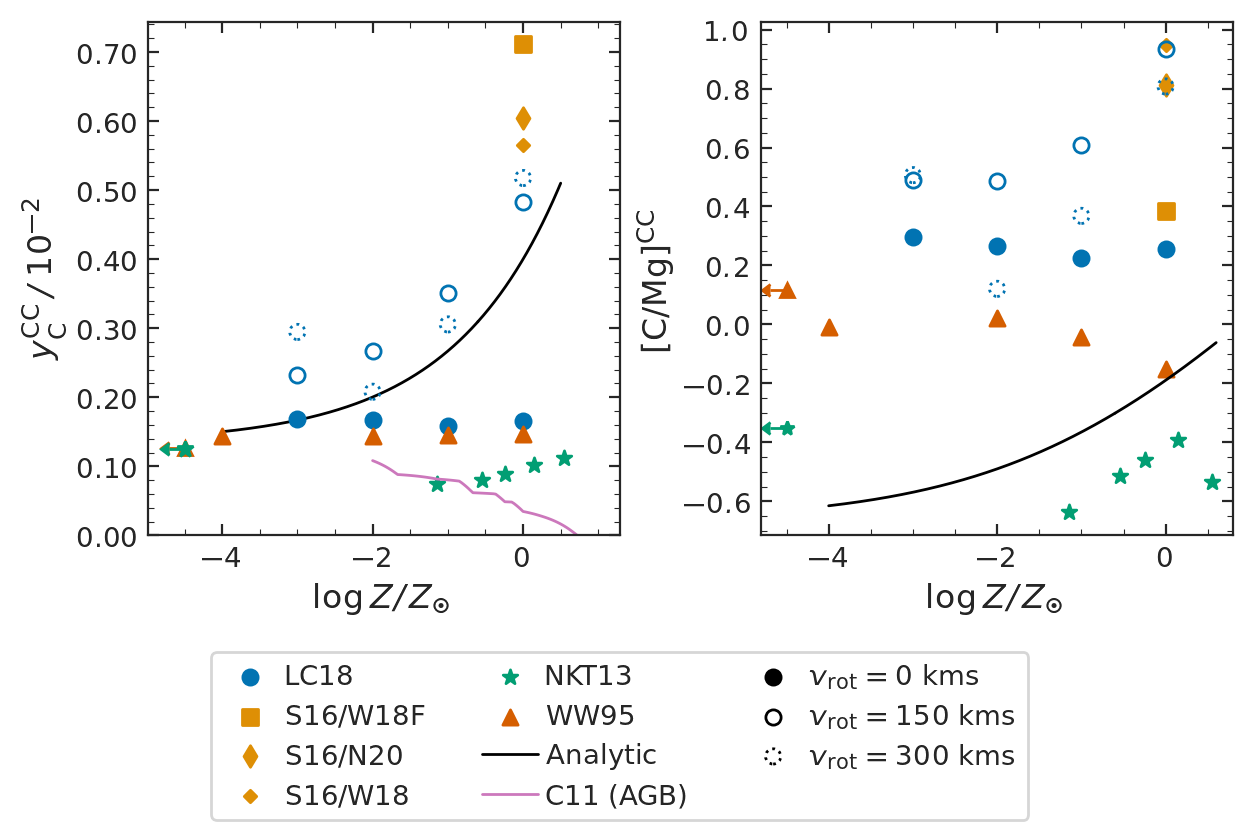

In [204]:
fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), gridspec_kw={"wspace": 0.3})

plt.sca(axs[0])


plot_y_cc()

plot_analy()
# plot AGB line
plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"$y_{\rm C}^{\rm CC}\,/\,10^{-2}$")

plt.ylim(0)


plot_c11()

l = []
for i in range(3):
    l.append(plt.scatter(np.NaN, np.NaN, ls=["-", "-", ":"][i],
                ec="k", facecolor=["k", "white", "white"][i], lw=1, s=30,
                label=r"$v_{\rm rot}=%i$ kms" % ([0, 150, 300][i])
               ))
    
l1 = plt.legend(bbox_to_anchor=(1,-0.2), loc="upper center", ncols=3, frameon=True)
xs = np.arange(0.00, 0.008, 0.001)
plt.yticks(xs, labels=["%0.2f" % a for a in 100*xs])



plt.sca(axs[1])




for i in range(len(ccsne_studies)):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]

    rotations = allowed_rotations[study]
    m_upper = M_max[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        yc = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        yo = [vice.yields.ccsne.fractional('mg', study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
              for metalicity in metalicities]
        y = np.log10(np.array(yc)/yo) - np.log10(vice.solar_z("c")/vice.solar_z("mg"))
                
        if i == 0 and j==2:
            pass
        print(metalicities)
      
        marker = markers[i]
        color = colors[i]
        if np.isinf(metalicities[0]):
            x0 = -4.5
            plt.errorbar(x0, y[0], xerr=[0.2], yerr=0, marker=marker, 
                         color=color, xuplims=[1], ms=5, capsize=0)
            x = metalicities[1:]
            y = y[1:]
        else:
            x = metalicities
        
        if rotation == 150:
            linestyle="-"
            facecolor=(1,1,1,0)
            label=""
            zorder = 2
        elif rotation == 300:
            linestyle = ":"
            facecolor=(1,1,1,0)
            label=""
            zorder = 3
        else:
            linestyle="-"
            facecolor = color
            label=study
            zorder = 1
        plt.scatter(x, y, edgecolors=color, label=label, zorder = zorder,
                    linestyle=linestyle, facecolors=facecolor, marker=marker, s=sizes[i])



m_h = np.linspace(-0.6, 0.6, 1000)
Z = 0.014*10**m_h
y = np.log10(y_c_cc(Z)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, color="k")

m_h = np.linspace(-4, -0.6, 1000)
Z = 0.014*10**m_h
y = np.log10(y_c_cc(Z)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, color="k", ls="-")


# final style things
plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"[C/Mg]$^\text{CC}$")
plt.xlim(-4.8, 0.8)



    
# plt.legend(handles =l, bbox_to_anchor=(0,-0.2), loc="upper left")


plt.savefig("cc_yields.pdf")